In [1]:
import pandas as pd
import json
import sqlite3
import pickle
import time 
from glob import glob
import numpy as np
from tqdm import tqdm
import os
import sys
import matplotlib.pylab as plt

sys.path.append('/Users/somov-od/Documents/phd/projects/RuSpider paper/rat-sql/')
from ratsql.datasets.spider_lib import evaluation, process_sql

%pylab inline

ModuleNotFoundError: No module named 'ratsql'

In [2]:
RUSPIDER_PROJECT_PATH = "/Users/somov-od/Documents/phd/projects/RuSpider paper"

### Check db intersect

In [5]:
ru_databases_dir_path_v1_train_bases = os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/mark-up-process/merged_database_done/train/merged_database/')
train_dbs = [name for name in os.listdir(ru_databases_dir_path_v1_train_bases)]

ru_databases_dir_path_v1_dev_bases = os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/mark-up-process/merged_database_done/dev/merged_database/')
dev_dbs = [name for name in os.listdir(ru_databases_dir_path_v1_dev_bases)]

ru_kate_databases_dir_path_v1_dev_bases = os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2ts/database/')
kate_dbs = [name for name in os.listdir(ru_databases_dir_path_v1_dev_bases)]

print('Intersect: ', len(set(train_dbs).intersection(set(dev_dbs))) / len(train_dbs))
print('Intersect: ', len(set(kate_dbs).intersection(set(dev_dbs))) / len(train_dbs))
print('Len: ', len(train_dbs), len(dev_dbs), len(kate_dbs))

Intersect:  1.0
Intersect:  1.0
Len:  167 167 167


### Evaluator prepare

In [9]:
ru_tables_path = os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2/tables.json')

ru_databases_dir_path_v2 = os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2/database/')
ru_kmaps_v2 = evaluation.build_foreign_key_map_from_json(ru_tables_path)
ru_evaluator_v2 = evaluation.Evaluator(ru_databases_dir_path_v2, ru_kmaps_v2, "all")

ru_kate_databases_dir_path = os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2ts/database/')
ru_kate_kmaps_v1= evaluation.build_foreign_key_map_from_json(ru_tables_path)
ru_kate_evaluator = evaluation.Evaluator(ru_kate_databases_dir_path, ru_kate_kmaps_v1, "all")

en_tables_path = os.path.join(RUSPIDER_PROJECT_PATH, 'spider/tables.json')
en_databases_dir_path = os.path.join(RUSPIDER_PROJECT_PATH, 'spider/database')
en_kmaps = evaluation.build_foreign_key_map_from_json(en_tables_path)
en_evaluator = evaluation.Evaluator(en_databases_dir_path, en_kmaps, "all")

### Read data

In [10]:
en_spider_train = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'spider/train_spider.json'), 'r'))
en_spider_train_others = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'spider/train_others.json'), 'r'))
en_spider_train = en_spider_train + en_spider_train_others
en_spider_dev = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'spider/dev.json'), 'r'))
en_spider = {'train': en_spider_train, 'dev': en_spider_dev}
print(len(en_spider['train']), len(en_spider['dev']))

8659 1034


In [11]:
ru_v2_spider_train = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2/train.json'), 'r'))
ru_v2_spider_dev = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2/dev.json'), 'r'))
ru_v2_spider = {'train': ru_v2_spider_train, 'dev': ru_v2_spider_dev}
print(len(ru_v2_spider['train']), len(ru_v2_spider['dev']))

8659 1034


In [12]:
ru_v2ts_spider_train = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2ts/train.json'), 'r'))
ru_v2ts_spider_dev = json.load(open(os.path.join(RUSPIDER_PROJECT_PATH, 'ruspider/vol_2ts/dev.json'), 'r'))
ru_v2ts_spider = {'train': ru_v2ts_spider_train, 'dev': ru_v2ts_spider_dev}
print(len(ru_v2ts_spider['train']), len(ru_v2ts_spider['dev']))

8820 1086


### Utils

In [13]:
def get_query_result(evaluator , query, db_name):
    db = evaluator.db_paths[db_name]
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    result = None
    try:
        cursor.execute(query)
    except sqlite3.OperationalError as e:
        result = 'db_execution_content_problem'
    if result is None:
        try:
            result = cursor.fetchall()
        except sqlite3.OperationalError as e:
            result = 'db_fetching_content_problem'
    return result

def validate_responce(db_responce):
    """Оценка рабочего gold запроса"""
    valid_responce = (True, 'all good')
    
    if len(db_responce) > 0 and type(db_responce) == list:
        values_list = list(set(map(lambda x: x[0], db_responce)))
        if ((len(values_list) == 1) & (values_list[0] == None)):
            valid_responce = (False, 'one none')
        elif ((len(values_list) == 1) & (values_list[0] == 0) & (len(db_responce[0]) == 1)):
            valid_responce = (False, 'one zero')
    elif 'content_problem' in db_responce:
        valid_responce = (False, 'database problem')
    elif db_responce == 0:
        valid_responce = (False, 'aggregation zero')
    elif len(db_responce) == 0:
        valid_responce = (False, 'empty list')
    
    return valid_responce

def get_table_df(evaluator, db_name, table_name):
    db = evaluator.db_paths[db_name]
    conn = sqlite3.connect(db)

    df = pd.read_sql(f'Select * FROM {table_name}', conn)
    return df

def get_tables_from_db(evaluator, db_name):
    db = evaluator.db_paths[db_name]
    conn = sqlite3.connect(db)
    df = pd.read_sql(f'SELECT name FROM sqlite_master WHERE type="table";', conn)
    return df

### Тулзы для анализа

In [14]:
get_tables_from_db(en_evaluator, 'academic')

,name
0,author
1,conference
2,domain
3,domain_author
4,domain_conference
5,journal
6,domain_journal
7,keyword
8,domain_keyword
9,publication


In [15]:
get_query_result(en_evaluator, en_gold_sql, en_db_name)

NameError: name 'en_gold_sql' is not defined

In [14]:
# в английском есть пустые БД???
def get_table_df(evaluator, db_name, table_name):
    db = evaluator.db_paths[db_name]
    conn = sqlite3.connect(db)
    df = pd.read_sql(f'Select * FROM {table_name}', conn)
    return df

get_table_df(ru_kate_evaluator, 'company_1', 'dependent')

,Essn,Dependent_name,Sex,Bdate,Relationship
0,333445555,Alice,Ж,1986-04-05,Daughter
1,333445555,Theodore,М,1983-10-25,Son
2,333445555,Joy,Ж,1958-05-03,Spouse
3,987654321,Abner,М,1942-02-28,Spouse
4,123456789,Michael,М,1988-01-04,Son
5,123456789,Alice,Ж,1988-12-30,Daughter
6,123456789,Elizabeth,Ж,1967-05-05,Spouse
7,123456789,Кристина,Ж,1988-01-04,Родственик
8,31515926,Констанция,Ж,1990-10-04,Племянник


### English spider

In [20]:
# train stats
en_failed_idx_dict = {'train': [], 'dev': []}
query_time_dict_en = {'train': [], 'dev': []}

for SPLIT_TYPE in en_spider:
    correct_counter = 0
    for idx, sample in tqdm(enumerate(en_spider[SPLIT_TYPE])):
        en_gold_sql, en_db_name = sample['query'], sample['db_id']
        
        start_time = time.time()
        en_exec_result = get_query_result(en_evaluator, en_gold_sql, en_db_name)
        end_time = time.time()
        query_time_dict_en[SPLIT_TYPE].append((end_time - start_time) * 1000)
        
        valid_responce_flag, exec_status = validate_responce(en_exec_result)
        if valid_responce_flag:
            correct_counter += 1
        else:
            en_failed_idx_dict[SPLIT_TYPE].append((idx, exec_status))
    print(f'Correct samples for {SPLIT_TYPE} = {correct_counter} from {len(en_spider[SPLIT_TYPE])} \
          ({correct_counter / len(en_spider[SPLIT_TYPE])})')
    
    

8659it [00:09, 867.45it/s] 


Correct samples for train = 6658 from 8659           (0.7689109596951149)


1034it [00:02, 384.53it/s]

Correct samples for dev = 955 from 1034           (0.9235976789168279)


### RuSpider

#### Vol 2

ПРоверим на 2ух эвалюаторах - трейне и тесте. Чтобы удостоверится что редачили старую бд.

In [25]:
ru_failed_idx_dict_v2 = {'train': [], 'dev': []}

for SPLIT_TYPE in ru_v2_spider:
    correct_counter = 0
    for idx, sample in tqdm(enumerate(ru_v2_spider[SPLIT_TYPE])):
        ru_gold_sql, ru_db_name = sample['query'], sample['db_id']
        
        ru_exec_result = get_query_result(ru_evaluator_v2, ru_gold_sql, ru_db_name)
      
        valid_responce_flag, exec_status = validate_responce(ru_exec_result)
        if valid_responce_flag:
            correct_counter += 1
        else:
            ru_failed_idx_dict_v2[SPLIT_TYPE].append((idx, exec_status))
    print(f'Correct samples for {SPLIT_TYPE} = {correct_counter} from {len(ru_v2_spider[SPLIT_TYPE])} ({correct_counter / len(ru_v2_spider[SPLIT_TYPE])})')

8659it [00:09, 908.08it/s] 


Correct samples for train = 8644 from 8659 (0.9982676983485391)


1034it [00:02, 382.25it/s]

Correct samples for dev = 1034 from 1034 (1.0)


### vol 2ts

In [15]:
ru_failed_idx_dict_ru_kate = {'train': [], 'dev': []}

for SPLIT_TYPE in ru_v2ts_spider:
    correct_counter = 0
    for idx, sample in tqdm(enumerate(ru_v2ts_spider[SPLIT_TYPE])):
        ru_gold_sql, ru_db_name = sample['query']['ru'], sample['db_id']
        ru_exec_result = get_query_result(ru_kate_evaluator, ru_gold_sql, ru_db_name)
        
        valid_responce_flag, exec_status = validate_responce(ru_exec_result)
        if valid_responce_flag:
            correct_counter += 1
        else:
            ru_failed_idx_dict_ru_kate[SPLIT_TYPE].append((idx, exec_status))
    print(f'Correct samples for {SPLIT_TYPE} = {correct_counter} from {len(ru_v2ts_spider[SPLIT_TYPE])} ({correct_counter / len(ru_v2ts_spider[SPLIT_TYPE])})')

8820it [00:09, 942.99it/s] 


Correct samples for train = 8800 from 8820 (0.9977324263038548)


1086it [00:02, 393.65it/s]

Correct samples for dev = 1074 from 1086 (0.988950276243094)


In [32]:
ru_v2_spider['train'][1147]

{'id': 'TO_8148',
 'db_id': 'yelp',
 'source': 'spider-train-others',
 'query': 'SELECT COUNT ( DISTINCT t3.text ) FROM category AS t2 JOIN business AS t1 ON t2.business_id  =  t1.business_id JOIN review AS t3 ON t3.business_id  =  t1.business_id WHERE t1.name  =  "Кафе Воронеж" AND t1.state  =  "Воронежская область" AND t2.category_name  =  "ресторан";',
 'question': 'найти количество отзывов, написанных о ресторане "Кафе Воронеж" в Воронежской области',
 'sql': {'from': {'table_units': [['table_unit', 1],
    ['table_unit', 0],
    ['table_unit', 5]],
   'conds': [[False, 2, [0, [0, 13, False], None], [0, 2, False], None],
    'and',
    [False, 2, [0, [0, 26, False], None], [0, 2, False], None]]},
  'select': [False, [[3, [0, [0, 29, True], None]]]],
  'where': [[False, 2, [0, [0, 3, False], None], '"Кафе Воронеж"', None],
   'and',
   [False, 2, [0, [0, 11, False], None], '"Воронежская область"', None],
   'and',
   [False, 2, [0, [0, 14, False], None], '"ресторан"', None]],
  'gro

In [112]:
ru_failed_idx_dict_ru_kate

{'train': [(2132, 'empty list'),
  (8141, 'empty list'),
  (8149, 'empty list'),
  (8150, 'empty list'),
  (8178, 'empty list'),
  (8188, 'one zero'),
  (8189, 'one none'),
  (8190, 'one none'),
  (8191, 'empty list'),
  (8192, 'empty list'),
  (8197, 'one zero'),
  (8205, 'one zero'),
  (8208, 'one zero'),
  (8210, 'one zero'),
  (8220, 'one zero'),
  (8225, 'one zero'),
  (8240, 'one zero'),
  (8742, 'empty list'),
  (8743, 'one zero'),
  (8744, 'empty list'),
  (8745, 'one zero'),
  (8746, 'one zero'),
  (8747, 'one none'),
  (8748, 'empty list'),
  (8749, 'empty list'),
  (8750, 'empty list'),
  (8751, 'one none'),
  (8752, 'empty list'),
  (8753, 'one none'),
  (8754, 'one none'),
  (8755, 'one zero'),
  (8756, 'one zero'),
  (8757, 'empty list'),
  (8758, 'empty list'),
  (8759, 'one zero'),
  (8760, 'one zero'),
  (8761, 'one zero')],
 'dev': [(455, 'database problem'),
  (456, 'database problem'),
  (1051, 'empty list'),
  (1052, 'one zero'),
  (1053, 'empty list'),
  (1054, 'e

In [16]:
len(ru_failed_idx_dict_ru_kate['train']), len(ru_failed_idx_dict_ru_kate['dev'])

(20, 12)

In [17]:
v2_idx = set([i[0] for i in ru_failed_idx_dict_v2['train']])
kate_idx = set([i[0] for i in ru_failed_idx_dict_ru_kate['train']])
v2_idx.intersection(kate_idx)

NameError: name 'ru_failed_idx_dict_v2' is not defined

In [18]:
from collections import Counter
errors = []
errors += [err[1] for err in ru_failed_idx_dict_ru_kate['train']]
errors += [err[1] for err in ru_failed_idx_dict_ru_kate['dev']]
Counter(errors)

Counter({'empty list': 14,
         'one zero': 10,
         'one none': 6,
         'database problem': 2})

In [105]:
json.dump(ru_failed_idx_dict_ru_kate, open('new_vol_3_db_fails.json', 'w'), indent=4, ensure_ascii=False)

In [19]:
result = get_query_result(ru_kate_evaluator, ru_v2ts_spider['train'][2132]['query']['ru'], ru_v2ts_spider['train'][2132]['db_id'])
print(result)
validate_responce(result)

[('Констанция',)]


(True, 'all good')

In [72]:
ru_v2ts_spider['dev'][1041]

{'id': 'B_0047',
 'db_id': 'concert_singer',
 'source': 'addition',
 'type': 'dev',
 'query': {'en': 'SELECT count( * ) FROM singer WHERE singer.Is_male = 0',
  'ru': "SELECT count( * ) FROM singer WHERE singer.Is_male = 'F'"},
 'question': {'en': 'Amount of female singers', 'ru': 'Количество певиц'},
 'sql': {'en': {'from': {'table_units': [['table_unit', 1]], 'conds': []},
   'select': [False, [[3, [0, [0, 0, False], None]]]],
   'where': [[False, 2, [0, [0, 14, False], None], 0.0, None]],
   'groupBy': [],
   'having': [],
   'orderBy': [],
   'limit': None,
   'intersect': None,
   'union': None,
   'except': None},
  'ru': {'from': {'table_units': [['table_unit', 1]], 'conds': []},
   'select': [False, [[3, [0, [0, 0, False], None]]]],
   'where': [[False, 2, [0, [0, 14, False], None], '"F"', None]],
   'groupBy': [],
   'having': [],
   'orderBy': [],
   'limit': None,
   'intersect': None,
   'union': None,
   'except': None}},
 'question_toks': {'en': ['Amount', 'of', 'female',

In [127]:
for split in ru_v2ts_spider:
    for idx, sample in enumerate(ru_v2ts_spider[split]):
        if sample['id'] == 'TS_2133':
            print(sample)
            print(idx)

{'id': 'TS_2133', 'db_id': 'company_1', 'source': 'spider-train', 'type': 'train', 'query': {'en': "SELECT Dependent_name FROM dependent WHERE relationship  =  'Spouse';", 'ru': "SELECT Dependent_name FROM dependent WHERE relationship  =  'Племянник';"}, 'question': {'en': 'find all dependent names who have a spouse relation with some employee.', 'ru': 'Найти все имена иждивенцев, являющихся племянником кого-то из сотрудников.'}, 'sql': {'en': {'from': {'table_units': [['table_unit', 4]], 'conds': []}, 'select': [False, [[0, [0, [0, 23, False], None]]]], 'where': [[False, 2, [0, [0, 26, False], None], '"Spouse"', None]], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect': None, 'union': None, 'except': None}, 'ru': {'from': {'table_units': [['table_unit', 4]], 'conds': []}, 'select': [False, [[0, [0, [0, 23, False], None]]]], 'where': [[False, 2, [0, [0, 26, False], None], '"Племянник"', None]], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect':

### Соберем эти подготовленные файлы в трейн

In [100]:
sample = ru_spider_v1['train'][0]
question, query, db_id = sample['question'], sample['query'], sample['db_id']
db_schema = ru_evaluator_v1_dev.schemas[db_id]
preprocessed_sql = process_sql.get_sql(db_schema, query)
preprocessed_sql

{'from': {'table_units': [('table_unit', '__head__')], 'conds': []},
 'select': (False, [(3, (0, (0, '__all__', False), None))]),
 'where': [(False, 3, (0, (0, '__head.age__', False), None), 56.0, None)],
 'groupBy': [],
 'having': [],
 'orderBy': [],
 'limit': None,
 'intersect': None,
 'union': None,
 'except': None}

In [98]:
for split in ru_spider_v1:
    for sample in ru_spider_v1[split]:
        question, query, db_id = sample['question'], sample['query'], sample['db_id']
        db_schema = ru_evaluator_v1_dev.schemas[db_id]
        preprocessed_sql = process_sql.get_sql(db_schema, query)

[{'question': 'Сколько руководителей отделов старше 56 лет?',
  'query': 'SELECT count(*) FROM head WHERE age  >  56;',
  'db_id': 'department_management'},
 {'question': 'Перечислите имена, место рождения и возраст руководителей отделов в порядке возрастов.',
  'query': 'SELECT name ,  born_state ,  age FROM head ORDER BY age;',
  'db_id': 'department_management'},
 {'question': 'Укажите год создания, название и бюджет каждого отдела.',
  'query': 'SELECT creation ,  name ,  budget_in_billions FROM department;',
  'db_id': 'department_management'},
 {'question': 'Каков максимальный и минимальный бюджет отделов?',
  'query': 'SELECT max(budget_in_billions) ,  min(budget_in_billions) FROM department;',
  'db_id': 'department_management'},
 {'question': 'Какова средняя численность сотрудников отделов с рейтингом от 10 до 15?',
  'query': 'SELECT avg(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15;',
  'db_id': 'department_management'},
 {'question': 'Как зовут глав, родивш

 ### One none problems

In [92]:
ru_failed_idx_dict_v1

{'train': [(2354, 'one none'),
  (2355, 'one none'),
  (3010, 'one none'),
  (3011, 'one none'),
  (5142, 'one none'),
  (5143, 'one none'),
  (5921, 'one none'),
  (5922, 'one none'),
  (5941, 'one none'),
  (5942, 'one none'),
  (5943, 'one none'),
  (5944, 'one none'),
  (6571, 'one none'),
  (6572, 'one none'),
  (7493, 'one none')],
 'dev': []}

In [102]:
for key in en_failed_idx_dict['train']:
    if key[1] == 'one none':
        print(key[0], en_spider['train'][key[0]])

2354 {'db_id': 'csu_1', 'query': 'SELECT avg(campusfee) FROM csu_fees WHERE YEAR  =  2005', 'query_toks': ['SELECT', 'avg', '(', 'campusfee', ')', 'FROM', 'csu_fees', 'WHERE', 'YEAR', '=', '2005'], 'query_toks_no_value': ['select', 'avg', '(', 'campusfee', ')', 'from', 'csu_fees', 'where', 'year', '=', 'value'], 'question': 'What is the average fee on a CSU campus in 2005?', 'question_toks': ['What', 'is', 'the', 'average', 'fee', 'on', 'a', 'CSU', 'campus', 'in', '2005', '?'], 'sql': {'from': {'table_units': [['table_unit', 1]], 'conds': []}, 'select': [False, [[5, [0, [0, 8, False], None]]]], 'where': [[False, 2, [0, [0, 7, False], None], 2005.0, None]], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect': None, 'union': None, 'except': None}}
2355 {'db_id': 'csu_1', 'query': 'SELECT avg(campusfee) FROM csu_fees WHERE YEAR  =  2005', 'query_toks': ['SELECT', 'avg', '(', 'campusfee', ')', 'FROM', 'csu_fees', 'WHERE', 'YEAR', '=', '2005'], 'query_toks_no_value': ['se

In [107]:
json.dump(en_failed_idx_dict, open('english_fails_idxs_list.json', 'w'), 
          ensure_ascii = False, indent=4)

In [104]:
k = 0
for key in ru_failed_idx_dict_v1['train']:
    if key[1] == 'one none':
        print(key[0], ru_spider_v1['train'][key[0]])
        k += 1
        
        
print(k)

2354 {'question': 'Какова средняя плата за обучение в кампусе CSU в 2005 году?', 'query': 'SELECT avg(campusfee) FROM csu_fees WHERE YEAR  =  2005;', 'db_id': 'csu_1'}
2355 {'question': 'Средняя плата за кампус CSU в 2005 году', 'query': 'SELECT avg(campusfee) FROM csu_fees WHERE YEAR  =  2005;', 'db_id': 'csu_1'}
3010 {'question': 'Найдите количество клиентов в банках Сочи.', 'query': "SELECT sum(no_of_customers) FROM bank WHERE city  =  'Сочи';", 'db_id': 'loan_1'}
3011 {'question': 'Каково общее количество клиентов, пользующихся услугами банков в Сочи?', 'query': "SELECT sum(no_of_customers) FROM bank WHERE city  =  'Сочи';", 'db_id': 'loan_1'}
5142 {'question': 'Каковы детали заказа товаров с ценой выше 2000?', 'query': 'SELECT T1.Other_Item_Details FROM ORDER_ITEMS AS T1 JOIN Products AS T2 ON T1.Product_ID  =  T2.Product_ID WHERE T2.Product_price  >  2000;', 'db_id': 'cre_Drama_Workshop_Groups'}
5143 {'question': 'Найдите детали заказа для продуктов с ценой выше 2000.', 'query': 

In [76]:
ru_sample_idx = 5921
en_sample = en_spider['train'][ru_sample_idx]
en_db_name, en_sql = en_sample['db_id'], en_sample['query']
print(en_sql)
ru_sample = ru_spider_v1['train'][ru_sample_idx]
ru_db_name, ru_sql = ru_sample['db_id'], ru_sample['query']
print(ru_sql)
en_exec_result = get_query_result(en_evaluator, en_sql, en_db_name)
print('En result: ', en_exec_result)

ru_exec_result = get_query_result(ru_evaluator_v1_train, ru_sql, ru_db_name)
print('Ru result: ',ru_exec_result)

ru_exec_result = get_query_result(ru_evaluator_v1_dev, ru_sql, ru_db_name)
print('Ru result: ',ru_exec_result)

print('Schema equivalence: ', (get_tables_from_db(ru_evaluator_v1_train, en_db_name).values == get_tables_from_db(ru_evaluator_v1_train, ru_db_name).values).all())
print('Db tables: ', get_tables_from_db(ru_evaluator_v1_train, en_db_name).values)

SELECT T1.Royal_Family_Details ,  T2.How_to_Get_There FROM ROYAL_FAMILY AS T1 JOIN TOURIST_ATTRACTIONS AS T2 ON T1.Royal_Family_ID  =  T2.Tourist_Attraction_ID
SELECT T1.Royal_Family_Details ,  T2.How_to_Get_There FROM ROYAL_FAMILY AS T1 JOIN TOURIST_ATTRACTIONS AS T2 ON T1.Royal_Family_ID  =  T2.Tourist_Attraction_ID;
En result:  [(None, 'bus'), (None, 'shuttle')]
Ru result:  [(None, 'bus'), (None, 'shuttle'), (None, 'трамвай'), (None, 'троллейбус'), (None, 'трамвай')]
Ru result:  [(None, 'bus'), (None, 'shuttle'), (None, 'трамвай'), (None, 'троллейбус'), (None, 'трамвай')]
Schema equivalence:  True
Db tables:  [['Ref_Hotel_Star_Ratings']
 ['Locations']
 ['Ref_Attraction_Types']
 ['Visitors']
 ['Features']
 ['Hotels']
 ['Tourist_Attractions']
 ['Street_Markets']
 ['Shops']
 ['Museums']
 ['Royal_Family']
 ['Theme_Parks']
 ['Visits']
 ['Photos']
 ['Staff']
 ['Tourist_Attraction_Features']]


In [77]:
get_table_df(en_evaluator, ru_db_name, 'ROYAL_FAMILY')

,Royal_Family_ID,Royal_Family_Details
0,9561,None
1,9919,None


In [79]:
get_table_df(ru_evaluator_v1_train, ru_db_name, 'ROYAL_FAMILY')

,Royal_Family_ID,Royal_Family_Details
0,9561,None
1,9919,None
2,9920,None
3,9921,None
4,9922,None


In [ ]:

# В оригинальном спайдере реально в выведенных ID'шниках есть колонки в которых не запролненны значения/есть невыполнимые условия, из-за которых None. 
# Разметчики их и не заполняли.

### En queries on russian db(на обновленном)

In [80]:
en_on_ru_failed_idx_dict_v1 = {'train': [], 'dev': []}
query_time_dict_en_on_ruv1 = {'train': [], 'dev': []}
for SPLIT_TYPE in en_spider:
    correct_counter = 0
    for idx, sample in tqdm(enumerate(en_spider[SPLIT_TYPE])):
        en_gold_sql, en_db_name = sample['query'], sample['db_id']
        
        start_time = time.time()
        en_on_ru_exec_result = get_query_result(ru_evaluator_v1_dev, en_gold_sql, en_db_name)
        end_time = time.time()
        query_time_dict_en_on_ruv1[SPLIT_TYPE].append((end_time - start_time) * 1000)
        
        valid_responce_flag, exec_status = validate_responce(en_on_ru_exec_result)
        if valid_responce_flag:
            correct_counter += 1
        else:
            en_on_ru_failed_idx_dict_v1[SPLIT_TYPE].append((idx, exec_status))
    print(f'Correct samples for {SPLIT_TYPE} = {correct_counter} from {len(en_spider[SPLIT_TYPE])} ({correct_counter / len(en_spider[SPLIT_TYPE])})')

8659it [00:11, 748.15it/s] 


Correct samples for train = 7015 from 8659 (0.8101397389998846)


1034it [00:03, 343.58it/s]

Correct samples for dev = 1018 from 1034 (0.9845261121856866)


### Качество разметки стало очень хорошим(проверяем почему)

In [108]:
en_failed_idx_dict

{'train': [(48, 'empty list'),
  (49, 'empty list'),
  (288, 'empty list'),
  (635, 'empty list'),
  (636, 'empty list'),
  (643, 'empty list'),
  (644, 'empty list'),
  (645, 'empty list'),
  (646, 'empty list'),
  (705, 'one zero'),
  (706, 'one zero'),
  (777, 'empty list'),
  (778, 'empty list'),
  (787, 'empty list'),
  (788, 'empty list'),
  (923, 'empty list'),
  (924, 'empty list'),
  (1165, 'empty list'),
  (1316, 'empty list'),
  (1390, 'empty list'),
  (1391, 'empty list'),
  (1430, 'empty list'),
  (1431, 'empty list'),
  (1456, 'empty list'),
  (1457, 'empty list'),
  (1470, 'empty list'),
  (1471, 'empty list'),
  (1472, 'empty list'),
  (1473, 'empty list'),
  (1478, 'empty list'),
  (1479, 'empty list'),
  (1632, 'empty list'),
  (1637, 'empty list'),
  (1643, 'empty list'),
  (1644, 'empty list'),
  (1683, 'empty list'),
  (1684, 'empty list'),
  (1701, 'empty list'),
  (1702, 'empty list'),
  (1895, 'empty list'),
  (1897, 'empty list'),
  (1954, 'empty list'),
  (201

In [22]:
en_failed_idx_dict['train'][:5]

[(48, 'empty list'),
 (49, 'empty list'),
 (288, 'empty list'),
 (635, 'empty list'),
 (636, 'empty list')]

In [195]:
#берем случайный семпл с empty list - смотрим что возвращает английский, смотрим что возвращает русский
en_sample_idx = 48
en_sample = en_spider['train'][en_sample_idx]
en_db_name, en_sql = en_sample['db_id'], en_sample['query']
print(en_sql)
ru_sample = ru_spider_v1['train'][en_sample_idx]
ru_db_name, ru_sql = ru_sample['db_id'], ru_sample['query']
print(ru_sql)
en_exec_result = get_query_result(en_evaluator, en_sql, en_db_name)
print('En result: ', en_exec_result)

ru_exec_result = get_query_result(ru_evaluator_v1, ru_sql, ru_db_name)
print('Ru result: ',ru_exec_result)

print('Schema equivalence: ', (get_tables_from_db(en_evaluator, en_db_name).values == get_tables_from_db(ru_evaluator_v1, ru_db_name).values).all())
print('Db tables: ', get_tables_from_db(en_evaluator, en_db_name).values)

SELECT Official_Name FROM city WHERE City_ID NOT IN (SELECT Host_city_ID FROM farm_competition)
SELECT Official_Name FROM city WHERE City_ID NOT IN (SELECT Host_city_ID FROM farm_competition);
En result:  []
Ru result:  [('Балашиха',)]
Schema equivalence:  True
Db tables:  [['city']
 ['farm']
 ['farm_competition']
 ['competition_record']]


In [194]:
ru_db_name

'twitter_1'

In [ ]:
#48,49 - мы добавили новые сущности в конец таблицы, но получилось, что добавление сущности полностью меняет ответ(так как была проверка по id, 
# а теперь появился id удоволетворяющий условиям)

#289 - они еще добавили связи между сущностями(там твиттер тема) - теперь запрос исполняется. Но теперь в SQL мы оперируем чисто над русскми сущностями. 
# То есть мы будто под наши запросы подделали БД. Правильно ли это?

#635 - сделали провязку по жанрам. теперь трек стал обладать новым id, по которому мы смогли вывести новые семплы. В том числе добавили и английские значения. 

# я не вижу что это плохо. Давай теперь исполним английский на русской бд - как это будет?

### En examples with sql errors

#### Train

In [85]:
query_time_dict_en_on_ruv1

{'train': [1.2688636779785156,
  0.5309581756591797,
  0.4191398620605469,
  0.3948211669921875,
  0.3631114959716797,
  0.36716461181640625,
  0.7531642913818359,
  0.4849433898925781,
  0.41484832763671875,
  0.4971027374267578,
  0.34618377685546875,
  0.3161430358886719,
  0.5068778991699219,
  0.4570484161376953,
  0.31828880310058594,
  0.26488304138183594,
  0.26702880859375,
  0.25177001953125,
  0.2741813659667969,
  0.2658367156982422,
  0.2522468566894531,
  0.25081634521484375,
  0.2880096435546875,
  0.4673004150390625,
  0.43320655822753906,
  0.3199577331542969,
  0.28014183044433594,
  0.2770423889160156,
  0.34618377685546875,
  0.26488304138183594,
  0.2620220184326172,
  0.25081634521484375,
  0.2570152282714844,
  0.24819374084472656,
  0.37407875061035156,
  0.4849433898925781,
  0.29397010803222656,
  0.26416778564453125,
  0.31495094299316406,
  0.27298927307128906,
  0.25916099548339844,
  0.2529621124267578,
  0.2598762512207031,
  0.2512931823730469,
  0.25486

In [86]:
k = 0
for key in ru_failed_idx_dict_v1['train']:
    if key[1] == 'database problem':
        db_id, sql = ru_spider_v1['train'][key[0]]['db_id'], ru_spider_v1['train'][key[0]]['query']
        print(key[0], db_id)
        print(sql)
        print()
        k += 1
        
        
for key in ru_failed_idx_dict_v1['dev']:
    if key[1] == 'database problem':
        db_id, sql = ru_spider_v1['dev'][key[0]]['db_id'], ru_spider_v1['dev'][key[0]]['query']
        print(key[0], db_id, sql)   
        k += 1
        
k

0

In [ ]:
k = 0
for key in en_failed_idx_dict['train']:
    if key[1] == 'database problem':
        db_id, sql = en_spider['train'][key[0]]['db_id'], en_spider['train'][key[0]]['query']
        print(key[0], db_id)
        print(sql)
        print()
        k += 1
        
        
for key in en_failed_idx_dict['dev']:
    if key[1] == 'database problem':
        db_id, sql = en_spider['dev'][key[0]]['db_id'], en_spider['dev'][key[0]]['query']
        print(key[0], db_id, sql)   
        k += 1
        
k

In [306]:
for idx in [3153, 4513, 4514]:
    print(ru_spider_v1['train'][idx]['query'])

SELECT T1.company_name FROM Third_Party_Companies AS T1 JOIN Maintenance_Contracts AS T2 ON T1.company_id  =  T2.maintenance_contract_company_id ORDER BY T2.contract_end_date DESC LIMIT 1;
SELECT document_name FROM documents GROUP BY document_type_code, document_structure_code ORDER BY count(*) DESC LIMIT 3;
SELECT document_name FROM documents GROUP BY document_type_code, document_structure_code ORDER BY count(*) DESC LIMIT 3;


In [17]:
for idx in [455, 456]:
    print(ru_spider_v1['dev'][idx]['query'])

SELECT first_name ,  last_name FROM players ORDER BY birth_date;
SELECT first_name ,  last_name FROM players ORDER BY birth_date;


In [ ]:
get_query_result(en_evaluator, "SELECT document_name FROM documents GROUP BY document_structure_code ORDER BY count(*) DESC LIMIT 3", 
                 en_spider['dev'][4513]['db_id'])

In [326]:
get_query_result(ru_evaluator_v1_dev, "SELECT first_name ,  last_name FROM players ORDER BY birth_date;", 
                 ru_spider_v1['dev'][458]['db_id'])

'db_fetching_content_problem'

In [333]:
get_query_result(en_evaluator, "SELECT first_name ,  last_name FROM players WHERE hand  =  'Л' ORDER BY birth_date;", 
                 en_spider['dev'][458]['db_id'])

[]

In [334]:
get_query_result(en_evaluator, "SELECT first_name ,  last_name FROM players WHERE hand  =  'Л' ORDER BY birth_date;", 
                 'wta_1')

[]

In [344]:
len(get_query_result(en_evaluator, "SELECT first_name ,  last_name FROM players WHERE hand  =  'L' ORDER BY birth_date;", 
                 'wta_1'))

487

In [346]:
get_query_result(ru_evaluator_v1_dev, "SELECT first_name ,  last_name FROM players WHERE hand  =  'Л' ORDER BY birth_date;", 
                 'wta_1')

[('Ann', 'Jones'),
 ('Wendy', 'Gilchrist'),
 ('Martina', 'Navratilova'),
 ('Mary', 'Carillo'),
 ('Katerina', 'Bohmova'),
 ('Petra', 'Delhees Jauch'),
 ('Nancy', 'Loeffler Caro'),
 ('Lise', 'Gregory'),
 ('Rene', 'Collins'),
 ('Nicole', 'Arendt'),
 ('Florencia', 'Labat'),
 ('Sabine', 'Appelmans'),
 ('Andreea', 'Ehritt Vanc'),
 ('Monica', 'Seles'),
 ('Gala', 'Leon Garcia'),
 ('Karen', 'Cross'),
 ('Julie', 'Pullin'),
 ('Vanessa', 'Webb'),
 ('Elena', 'Tatarkova'),
 ('Anca', 'Barna'),
 ('Francesca', 'Lubiani'),
 ('Gaelle', 'Widmer'),
 ('Amanda', 'Keen'),
 ('Amanda', 'Augustus'),
 ('Rita', 'Kuti Kis'),
 ('Amelie', 'Cocheteux'),
 ('Amelie', 'Castera'),
 ('Saori', 'Obata'),
 ('Marine', 'Nizri Spiegel'),
 ('Patty', 'Schnyder'),
 ('Julie', 'Ditty'),
 ('Joana', 'Cortez'),
 ('Barbara', 'Schwartz'),
 ('Ludmilla', 'Varmuza'),
 ('Magui', 'Serna'),
 ('Amanda', 'Grahame'),
 ('Kim', 'Kilsdonk'),
 ('Emilie', 'Loit'),
 ('Erika', 'Pineider'),
 ('Anne Gaelle', 'Sidot'),
 ('Erica', 'Biro'),
 ('Stephanie', 'Ko

In [47]:
get_query_result(ru_evaluator_v1_dev, "SELECT first_name  FROM players where first_name == 'Selin Golseren';", 'wta_1')

[('Selin Golseren',)]

In [44]:
get_query_result(ru_evaluator_v1_dev, "SELECT last_name FROM players ;", 'wta_1')

[('Hingis',),
 ('Lucic',),
 ('Henin',),
 ('Guse',),
 ('Watanabe Giltz',),
 ('Habsudova',),
 ('Talaja',),
 ('Molik',),
 ('Tanasugarn',),
 ('Grande',),
 ('Srebotnik',),
 ('Nejedly',),
 ('Gavaldon',),
 ('Obziler',),
 ('Mandula',),
 ('Testud',),
 ('Sanchez Vicario',),
 ('Abe',),
 ('Fusai',),
 ('Raymond',),
 ('Dechaume Balleret',),
 ('Gagliardi',),
 ('Stewart',),
 ('Vento Kabchi',),
 ('Cervanova',),
 ('Labat',),
 ('Serna',),
 ('Drake',),
 ('Mcshea',),
 ('Vavrinec',),
 ('Tu',),
 ('Schett',),
 ('Williams',),
 ('Grahame',),
 ('Sanchez Lorenzo',),
 ('Pratt',),
 ('Appelmans',),
 ('Ellwood',),
 ('Rubin',),
 ('Smashnova',),
 ('Frazier',),
 ('Callens',),
 ('Razzano',),
 ('Chladkova',),
 ('Snyder',),
 ('Shaughnessy',),
 ('Nola',),
 ('Likhovtseva',),
 ('Martinez',),
 ('Kleinova',),
 ('Spirlea',),
 ('Barabanschikova',),
 ('Bacheva',),
 ('Plischke',),
 ('Diaz Oliva',),
 ('Kostanic Tosic',),
 ('De Lone',),
 ('Foldenyi Dicker',),
 ('Dragomir Ilie',),
 ('Garbin',),
 ('Leon Garcia',),
 ('Brandi',),
 ('Pano

In [348]:
get_table_df(ru_evaluator_v1_dev, 'wta_1', 'players')

OperationalError: Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'

In [322]:
ru_spider_v1['dev'][457]['db_id']

'wta_1'

In [321]:
ru_spider_v1['dev'][450:460]

[{'question': 'Сколько матчей было сыграно в 2013 или 2016?',
  'query': 'SELECT count(*) FROM matches WHERE YEAR  =  2013 OR YEAR  =  2016;',
  'db_id': 'wta_1'},
 {'question': 'Каковы коды страны и имена игроков, победивших в турнирах чемпионата по фрисби и Россия Первая?',
  'query': "SELECT T1.country_code ,  T1.first_name FROM players AS T1 JOIN matches AS T2 ON T1.player_id  =  T2.winner_id WHERE T2.tourney_name  =  'Чемпионат по фрисби' INTERSECT SELECT T1.country_code ,  T1.first_name FROM players AS T1 JOIN matches AS T2 ON T1.player_id  =  T2.winner_id WHERE T2.tourney_name  =  'Россия Первая';",
  'db_id': 'wta_1'},
 {'question': 'Какие имена и коды стран у игроков, выигравших в чемпионате по фрисби и в Россия Первая?',
  'query': "SELECT T1.country_code ,  T1.first_name FROM players AS T1 JOIN matches AS T2 ON T1.player_id  =  T2.winner_id WHERE T2.tourney_name  =  'Чемпионат по фрисби' INTERSECT SELECT T1.country_code ,  T1.first_name FROM players AS T1 JOIN matches AS T2 

In [27]:
query = """DESCRIBE 'players';"""
print(query)

get_query_result(ru_evaluator_v1_dev, query, 'wta_1')

DESCRIBE 'players';
near "DESCRIBE": syntax error


'db_execution_content_problem'

In [34]:
get_tables_from_db(ru_evaluator_v1_dev, 'wta_1')

,name
0,players
1,matches
2,rankings


In [33]:
ru_evaluator_v1_dev.db_paths['wta_1']

'/Users/somov-od/Documents/phd/projects/RuSpider paper/ruspider/mark-up-process/merged_database_done/dev/merged_database/wta_1/wta_1.sqlite'

In [30]:
dir(ru_evaluator_v1_dev)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'db_dir',
 'db_paths',
 'etype',
 'eval_exact_match',
 'eval_hardness',
 'eval_partial_match',
 'evaluate_one',
 'finalize',
 'kmaps',
 'schemas',
 'scores']

In [48]:
get_table_df(ru_evaluator_v1_dev, 'wta_1', 'players')

,player_id,first_name,last_name,hand,birth_date,country_code
0,200001,Martina,Hingis,R,19800930,SUI
1,200002,Mirjana,Lucic,R,19820309,CRO
2,200003,Justine,Henin,R,19820601,BEL
3,200004,Kerry Anne,Guse,R,19721204,AUS
4,200005,Jolene,Watanabe Giltz,R,19680831,USA
...,...,...,...,...,...,...
20661,220672,Milana,Zhabrailova,U,20030210,RUS
20662,100001,Слава,Мирный,Л,19820601,АФК
20663,100002,Мирон,Сивов,Л,19800930,УЗК
20664,100003,Федор,Денисов,П,19820601,УЗК


In [49]:
get_table_df(en_evaluator, 'wta_1', 'players')

OperationalError: Could not decode to UTF-8 column 'last_name' with text 'Treyes Albarrac��N'

In [359]:
get_table_df(en_evaluator, 'cre_Doc_Template_Mgt', 'Templates')

,Template_ID,Version_Number,Template_Type_Code,Date_Effective_From,Date_Effective_To,Template_Details
0,0,5,PP,2005-11-12 07:09:48,2008-01-05 14:19:28,
1,1,9,PP,2010-09-24 01:15:11,1999-07-08 03:31:04,
2,4,4,BK,2002-03-02 14:39:49,2001-04-18 09:29:52,
3,6,2,PPT,1975-05-20 22:51:19,1992-05-02 20:06:11,
4,7,8,PPT,1993-10-07 02:33:04,1975-07-16 04:52:10,
5,8,3,BK,1983-07-16 21:16:16,1976-10-28 10:08:50,
6,9,2,BK,1997-04-17 08:29:44,1994-12-07 13:26:23,
7,10,1,PPT,2003-06-05 04:03:45,2007-06-06 06:18:53,
8,11,6,BK,1996-02-04 11:27:24,1995-09-19 22:27:48,
9,14,7,AD,1975-10-20 02:28:58,1979-11-04 08:58:39,


In [82]:
for key in ru_failed_idx_dict_v1['dev']:
    if key[1] == 'one zero':
        db_id, sql = ru_spider_v1['dev'][key[0]]['db_id'], ru_spider_v1['dev'][key[0]]['query']
        print(db_id, sql)
        result = get_query_result(ru_evaluator_v1_dev, sql, db_id)
        print(result)

### Ru to En diff

In [24]:
print('Общее количество фейлов En train: ', len(en_failed_idx_dict['train']))
print('Общее количество фейлов En dev: ', len(en_failed_idx_dict['dev']))

Общее количество фейлов En train:  2001
Общее количество фейлов En dev:  79


In [29]:
print('Общее количество фейлов RuV2: ', len(ru_failed_idx_dict_v2['train']))
instersect_train = set(ru_failed_idx_dict_v2['dev']).intersection(set(en_failed_idx_dict['train']))
print('Количество пересечений ошибок RuV2 с En train: ', len(instersect_train))
print('vol2 Intersection percent: ', len(instersect_train) / len(en_failed_idx_dict['train']))
print()
print('Общее количество фейлов RuKate: ', len(ru_failed_idx_dict_ru_kate['dev']))
instersect_dev = set(ru_failed_idx_dict_ru_kate['dev']).intersection(set(en_failed_idx_dict['dev']))
print('Количество пересечений ошибок RuKate с En dev: ', len(instersect_dev))
print('RuKate Intersection percent: ', len(instersect_dev) / len(en_failed_idx_dict['dev']))

Общее количество фейлов RuV2:  15
Количество пересечений ошибок RuV2 с En train:  0
vol2 Intersection percent:  0.0

Общее количество фейлов RuKate:  6
Количество пересечений ошибок RuKate с En dev:  2
RuKate Intersection percent:  0.02531645569620253


En error distrs:  {'train': {'one none': 47, 'one zero': 335, 'database problem': 3, 'aggregation zero': 0, 'empty list': 1616}, 'dev': {'one none': 4, 'one zero': 24, 'database problem': 2, 'aggregation zero': 0, 'empty list': 49}}
RuV1 error distrs:  {'train': {'one none': 15, 'one zero': 0, 'database problem': 0, 'aggregation zero': 0, 'empty list': 0}, 'dev': {'one none': 0, 'one zero': 0, 'database problem': 0, 'aggregation zero': 0, 'empty list': 0}}


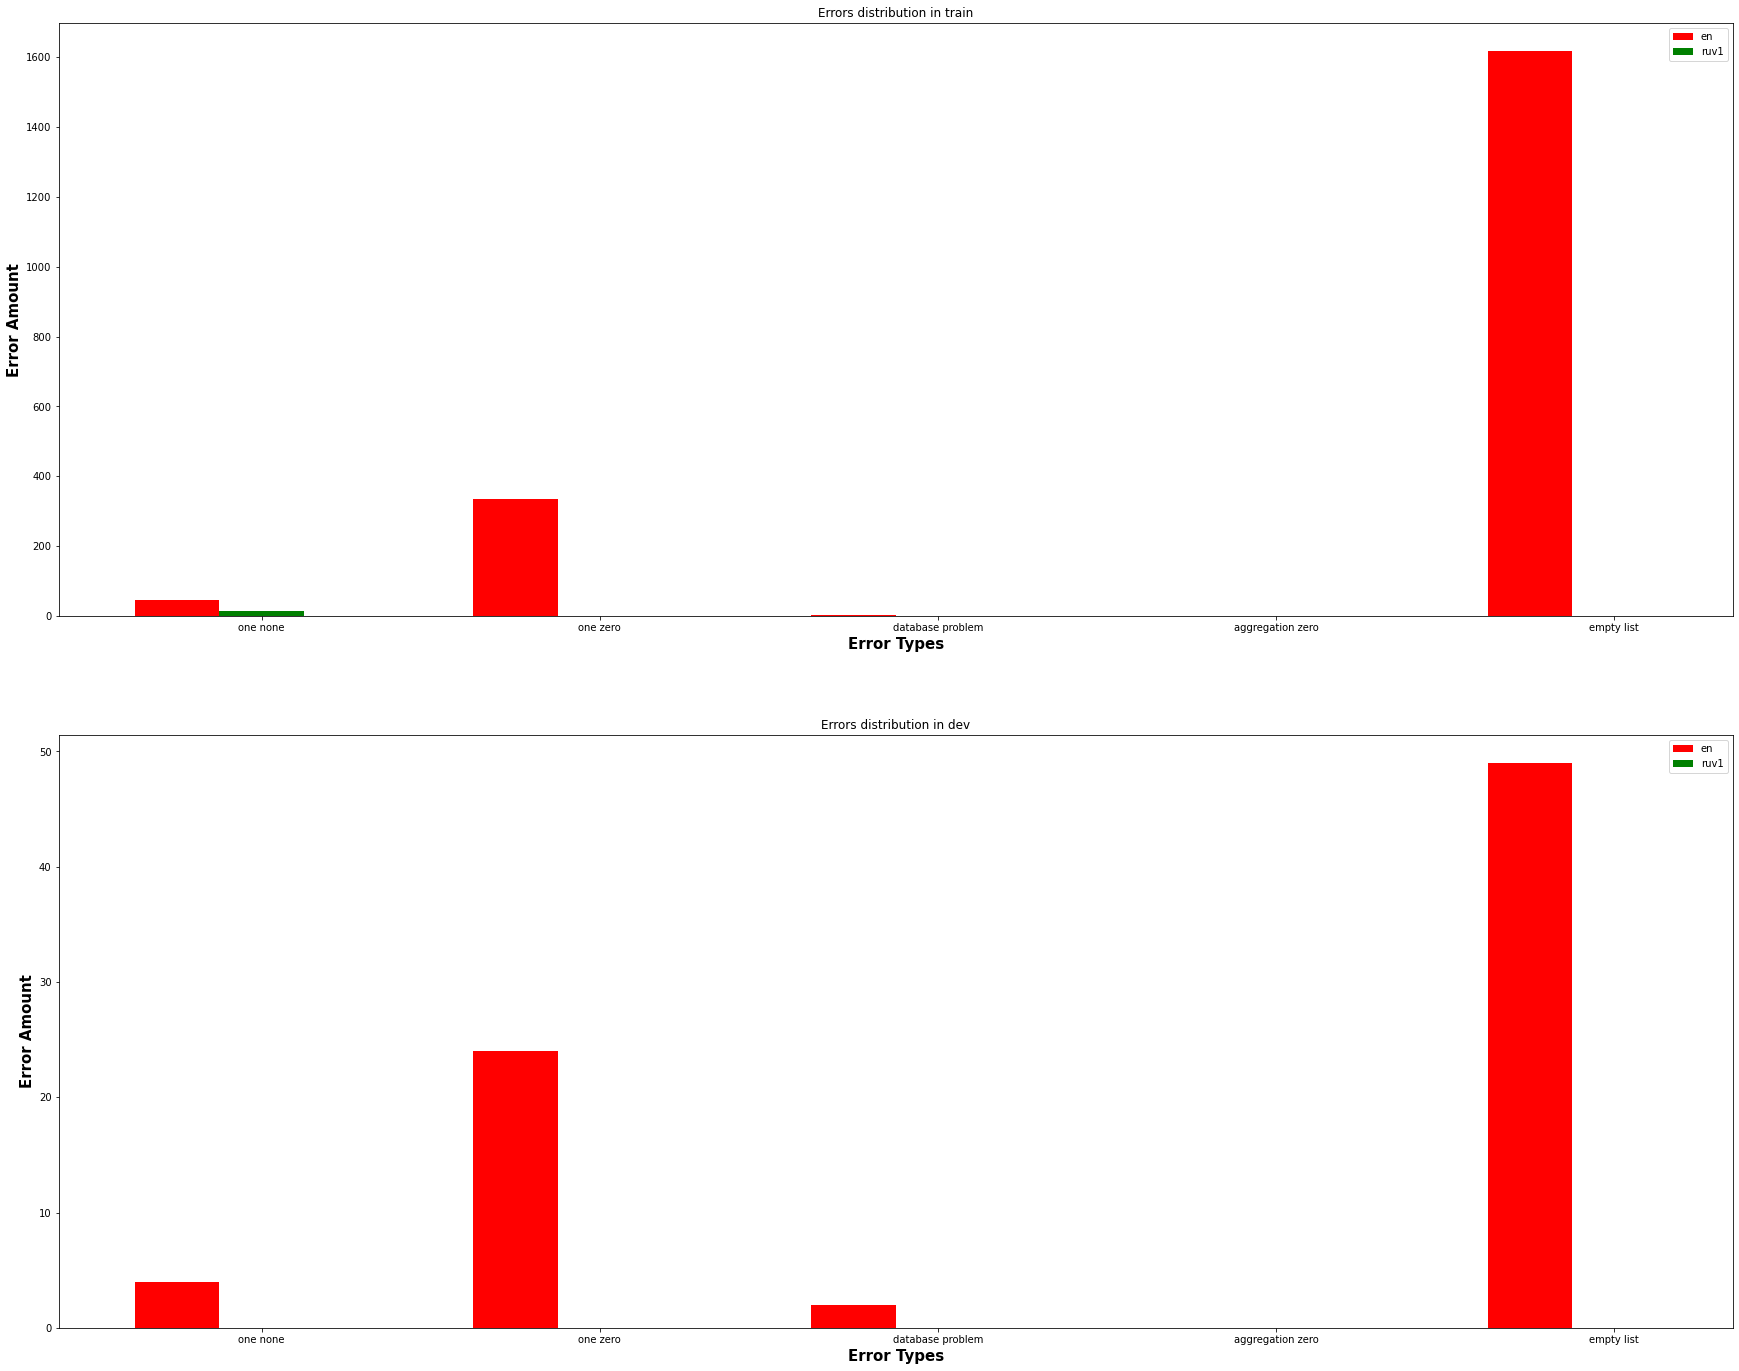

In [91]:
### problems distirbution
from copy import deepcopy
error_types_dict = {'one none': 0, 'one zero': 0, 'database problem': 0,
                   'aggregation zero': 0, 'empty list': 0}


problems_dict_en, problems_dict_RuV1 = dict(), dict()
for split in en_spider:
    #считаем ошибки - dev, train
    problems_dict_en[split] = deepcopy(error_types_dict)
    for sample in en_failed_idx_dict[split]:
        problems_dict_en[split][sample[1]] += 1

    problems_dict_RuV1[split] = deepcopy(error_types_dict)
    for sample in ru_failed_idx_dict_v1[split]:
        problems_dict_RuV1[split][sample[1]] += 1
            
print('En error distrs: ', problems_dict_en)
print('RuV1 error distrs: ', problems_dict_RuV1)

fig = plt.subplots(figsize =(30,24))
errors_list = list(error_types_dict.keys())

for idx, split in enumerate(en_spider):
    plt.subplot(2, 1, idx + 1)
    barWidth = 0.25
    br1 = np.arange(len(errors_list))
    br2 = [x + barWidth for x in br1]

    en_errors = list(problems_dict_en[split].values())
    ruv1_errors = list(problems_dict_RuV1[split].values())

    plt.bar(br1, en_errors,  color = 'r', width = barWidth, label='en')
    plt.bar(br2, ruv1_errors, color = 'g', width = barWidth, label='ruv1')
    plt.xlabel('Error Types', fontweight ='bold', fontsize = 15)
    plt.ylabel('Error Amount', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(errors_list))], errors_list)
    plt.title(f'Errors distribution in {split}')
    plt.legend()
    
plt.savefig("error_stat.png") 

In [126]:
len(en_failed_idx_dict['train']), len(en_failed_idx_dict['dev'])

(2001, 79)

In [137]:
en_spider['train'][0]

{'db_id': 'department_management',
 'query': 'SELECT count(*) FROM head WHERE age  >  56',
 'query_toks': ['SELECT',
  'count',
  '(',
  '*',
  ')',
  'FROM',
  'head',
  'WHERE',
  'age',
  '>',
  '56'],
 'query_toks_no_value': ['select',
  'count',
  '(',
  '*',
  ')',
  'from',
  'head',
  'where',
  'age',
  '>',
  'value'],
 'question': 'How many heads of the departments are older than 56 ?',
 'question_toks': ['How',
  'many',
  'heads',
  'of',
  'the',
  'departments',
  'are',
  'older',
  'than',
  '56',
  '?'],
 'sql': {'from': {'table_units': [['table_unit', 1]], 'conds': []},
  'select': [False, [[3, [0, [0, 0, False], None]]]],
  'where': [[False, 3, [0, [0, 10, False], None], 56.0, None]],
  'groupBy': [],
  'having': [],
  'orderBy': [],
  'limit': None,
  'intersect': None,
  'union': None,
  'except': None}}

In [142]:
# для разметки англа отберем те семплы, где возращается None или ошибка базы
print(len(en_failed_idx_dict['train']), len(en_failed_idx_dict['dev']))

failed_samples_for_markup = {
    "split": [],
    "spider_idx": [],
    "question": [], 
    "sql": [],
    "db_id": [],
    "problem": []
}

for split in en_failed_idx_dict:
    for sample in en_failed_idx_dict[split]:
        if sample[1] == 'one none' or sample[1] == 'database problem':
            spider_sample_idx = sample[0]
            question, sql, db_id = en_spider[split][spider_sample_idx]['question'], en_spider[split][spider_sample_idx]['query'], \
                                    en_spider[split][spider_sample_idx]['db_id']
            
            failed_samples_for_markup['split'].append(split)
            failed_samples_for_markup['spider_idx'].append(spider_sample_idx)
            failed_samples_for_markup['question'].append(question)
            failed_samples_for_markup['sql'].append(sql)
            failed_samples_for_markup['db_id'].append(db_id)
            failed_samples_for_markup['problem'].append(sample[1])
            
english_remark_df = pd.DataFrame(failed_samples_for_markup)
print(english_remark_df['problem'].value_counts())
print(english_remark_df.head())

english_remark_df.to_excel('english_for_remark_NONE&DBP.xlsx')

2001 79
one none            51
database problem     5
Name: problem, dtype: int64
   split  spider_idx                                           question  \
0  train        2354   What is the average fee on a CSU campus in 2005?   
1  train        2355  What is the average fee for a CSU campus in th...   
2  train        3092                    Return all detention summaries.   
3  train        3113  Find the texts of assessment notes for teacher...   
4  train        3153  What is the description of the type of the com...   

                                                 sql                db_id  \
0  SELECT avg(campusfee) FROM csu_fees WHERE YEAR...                csu_1   
1  SELECT avg(campusfee) FROM csu_fees WHERE YEAR...                csu_1   
2            SELECT detention_summary FROM Detention  behavior_monitoring   
3  SELECT T1.text_of_notes FROM Assessment_Notes ...  behavior_monitoring   
4  SELECT T1.company_name FROM Third_Party_Compan...   assets_maintenance   

    

In [135]:
failed_samples_for_markup

{'train': [(2354, 'one none'),
  (2355, 'one none'),
  (3092, 'one none'),
  (3113, 'one none'),
  (3153, 'database problem'),
  (4513, 'database problem'),
  (4514, 'database problem'),
  (5142, 'one none'),
  (5143, 'one none'),
  (5901, 'one none'),
  (5902, 'one none'),
  (5921, 'one none'),
  (5922, 'one none'),
  (5941, 'one none'),
  (5942, 'one none'),
  (5943, 'one none'),
  (5944, 'one none'),
  (7211, 'one none'),
  (7212, 'one none'),
  (7213, 'one none'),
  (7214, 'one none'),
  (7239, 'one none'),
  (7240, 'one none'),
  (7320, 'one none'),
  (7321, 'one none'),
  (7322, 'one none'),
  (7323, 'one none'),
  (7392, 'one none'),
  (7493, 'one none'),
  (7496, 'one none'),
  (7532, 'one none'),
  (7533, 'one none'),
  (7546, 'one none'),
  (8119, 'one none'),
  (8189, 'one none'),
  (8190, 'one none'),
  (8194, 'one none'),
  (8199, 'one none'),
  (8200, 'one none'),
  (8201, 'one none'),
  (8221, 'one none'),
  (8228, 'one none'),
  (8344, 'one none'),
  (8355, 'one none'),

In [127]:
len(failed_samples_for_markup['train']), len(failed_samples_for_markup['dev'])

(1000, 39)

In [93]:
#avg time per query
print('Average time per query RuV0 train: ', np.mean(query_time_dict_ruv0['train']))
print('Average time per query RuV1 train: ',np.mean(query_time_dict_ruv1['train']))
print('Average time per query En train: ',np.mean(query_time_dict_en['train']))
print()
print('Average time per query RuV0 dev: ', np.mean(query_time_dict_ruv0['dev']))
print('Average time per query RuV1 dev: ',np.mean(query_time_dict_ruv1['dev']))
print('Average time per query En dev: ',np.mean(query_time_dict_en['dev']))

Average time per query RuV0 train:  59.27457612854103
Average time per query RuV1 train:  1.1651147553188062
Average time per query En train:  1.1363349151963766

Average time per query RuV0 dev:  24.295820488920526
Average time per query RuV1 dev:  2.905332604044872
Average time per query En dev:  2.8678280241945955


In [272]:
TOP_K = 10

ind = np.argpartition(query_time_dict_ruv0['train'], -TOP_K)[-TOP_K:]
print(ind)
print(np.array(query_time_dict_ruv0['train'])[ind])
print()
ind = np.argpartition(query_time_dict_ruv1['train'], -TOP_K)[-TOP_K:]
print(ind)
print(np.array(query_time_dict_ruv1['train'])[ind])

[5317 5316 2956 2960 3113 3114 5320 1815 1814 5321]
[  1106.60791397   1151.4518261    1738.74092102   1621.28186226
   1848.65403175   1838.05704117 150185.82010269  91050.92406273
  92241.94979668 148469.60306168]

[1306 1297  155  156 3659 3661 3658 3657 3662 3660]
[105.44514656 185.61577797 259.13023949 265.55609703 925.52232742
 726.22418404 870.04709244 846.5077877  718.64199638 866.46914482]


In [273]:
sample_en = en_spider['train'][5321]
sample_v0 = ru_spider_v0['train'][5321]
sample_v1 = ru_spider_v1['train'][5321]

print(sample_en['question'])
print('En:', sample_en['query'])
print()
print(sample_v0['question'])
print('RuV0:', sample_v0['query'])
print()

print(sample_v1['question'])
print('RuV1:', sample_v1['query'])

How many products are there for each manufacturer?
En: SELECT count(*) ,  T2.name FROM products AS T1 JOIN manufacturers AS T2 ON T1.Manufacturer  =  T2.code GROUP BY T2.name

Какие игроки выиграли награды в 1960 и 1961 годах? Показать их имена и фамилии.
RuV0: SELECT T1.name_first , T1.name_last FROM player AS T1 JOIN player_award AS T2 WHERE T2.year  =  1960 INTERSECT SELECT T1.name_first , T1.name_last FROM player AS T1 JOIN player_award AS T2 WHERE T2.year  =  1961

Сколько продуктов есть у каждого производителя?
RuV1: SELECT count(*) ,  T2.name FROM products AS T1 JOIN manufacturers AS T2 ON T1.Manufacturer  =  T2.code GROUP BY T2.name;


In [94]:
!pwd

/Users/somov-od/Documents/phd/projects/RuSpider paper/ruspider/mark-up-process


### Отберем сломанные семплы из английского

In [274]:
broken_samples = []
for sample in en_failed_idx_dict['train']:
    if sample[1] == 'database problem':
        broken_samples.append({'en': en_spider['train'][sample[0]], 
                               'ru': ru_spider_v1['train'][sample[0]]})
        
broken_samples

[{'en': {'db_id': 'assets_maintenance',
   'query': 'SELECT T1.company_name FROM Third_Party_Companies AS T1 JOIN Maintenance_Contracts AS T2 ON T1.company_id  =  T2.maintenance_contract_company_id JOIN Ref_Company_Types AS T3 ON T1.company_type_code  =  T3.company_type_code ORDER BY T2.contract_end_date DESC LIMIT 1',
   'query_toks': ['SELECT',
    'T1.company_name',
    'FROM',
    'Third_Party_Companies',
    'AS',
    'T1',
    'JOIN',
    'Maintenance_Contracts',
    'AS',
    'T2',
    'ON',
    'T1.company_id',
    '=',
    'T2.maintenance_contract_company_id',
    'JOIN',
    'Ref_Company_Types',
    'AS',
    'T3',
    'ON',
    'T1.company_type_code',
    '=',
    'T3.company_type_code',
    'ORDER',
    'BY',
    'T2.contract_end_date',
    'DESC',
    'LIMIT',
    '1'],
   'query_toks_no_value': ['select',
    't1',
    '.',
    'company_name',
    'from',
    'third_party_companies',
    'as',
    't1',
    'join',
    'maintenance_contracts',
    'as',
    't2',
    'on'